

> Grace Esther



# **1A. Office Energy Consumption (Regression)**

This dataset contains information about energy consumption in a building (office), along with various environmental and temporal factors. Each row represents a specific hour and day, and the columns provide details about the conditions and energy usage during that time.

The columns in the dataset are as follows:

- **Month (Integer):** The month of the year (e.g., 1 for January, 12 for December).
- **Hour (Integer):** The hour of the day in 24-hour format (e.g., 0 for midnight, 12 for noon, 23 for 11 PM).
- **DayOfWeek (String):** The day of the week (e.g., Monday, Tuesday, ..., Sunday).
- **Holiday (String):** A categorical variable indicating whether the day was a holiday ('Yes') or not ('No').
- **Temperature (Float):** The ambient temperature in degrees Celsius (°C).
- **Humidity (Float):** The relative humidity as a percentage (%).
- **SquareFootage (Float):** The size of the building or space in square feet (sq ft).
- **Occupancy (Integer):** The number of people present in the space.
- **HVACUsage (String):** A categorical variable indicating whether the Heating, Ventilation, and Air Conditioning (HVAC) system was (on) or (off).
- **LightingUsage (String):** A categorical variable indicating whether the lighting was (on) or (off).
- **RenewableEnergy (Float):** The amount of energy generated from renewable sources, likely in kilowatt-hours (kWh).
- **EnergyConsumption (Float):** The total energy consumed by the building or space during that hour, likely in kilowatt-hours (kWh).

In [821]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, regularizers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam, RMSprop

from keras_tuner import HyperModel

In [770]:
df = pd.read_parquet('dataset_1A.parquet')
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


# **A. Exploratory Data Analysis and Pre-processing**

## EDA

Lakukan Exploratory Data Analysis (EDA) untuk memahami kondisi data. Jelaskan semua masalah yang anda temukan pada dataset anda. Lakukan pre-processing pada dataset anda sesuai dengan hasil EDA anda, termasuk memisahkan dataset anda menjadi train, val, dan test dengan proporsi 70:10:20.

In [771]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


In [772]:
df['Month'].value_counts()

,count
Month,
1,189
4,119
10,115
3,100
12,99
6,95
11,93
8,90
7,88


In [773]:
month_mapping = {
    'jan': 1, 'january': 1, '1': 1,
    'feb': 2, 'february': 2, '2': 2,
    'mar': 3, 'march': 3, '3': 3,
    'apr': 4, 'april': 4, '4': 4,
    'may': 5, '5': 5,
    'jun': 6, 'june': 6, '6': 6,
    'jul': 7, 'july': 7, '7': 7,
    'aug': 8, 'august': 8, '8': 8,
    'sep': 9, 'september': 9, '9': 9,
    'oct': 10, 'october': 10, '10': 10,
    'nov': 11, 'november': 11, '11': 11,
    'dec': 12, 'december': 12, '12': 12
}

df['Month'] = df['Month'].astype(str).str.lower().map(month_mapping)

In [774]:
df['Occupancy'].value_counts()

,count
Occupancy,
7,145
9,142
6,138
0,131
3,130
2,128
4,114
5,105
8,105


In [775]:
df = df[df["Occupancy"] >= 0]

In [776]:
df['EnergyConsumption'].value_counts()

,count
EnergyConsumption,
53.263278,11
99.20112,8
nan,3
86.95102003760138,1
82.01743618687475,1
...,...
79.33483356260274,1
80.0038474890762,1
66.31211986951728,1


In [777]:
df["EnergyConsumption"] = pd.to_numeric(df["EnergyConsumption"], errors="coerce")
df['EnergyConsumption'] = df['EnergyConsumption'].fillna(df['EnergyConsumption'].mean())

<ipython-input-777-bdccbd26e512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["EnergyConsumption"] = pd.to_numeric(df["EnergyConsumption"], errors="coerce")
<ipython-input-777-bdccbd26e512>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EnergyConsumption'] = df['EnergyConsumption'].fillna(df['EnergyConsumption'].mean())


In [778]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1231 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1231 non-null   int64  
 1   Hour               1231 non-null   int64  
 2   DayOfWeek          1231 non-null   object 
 3   Holiday            1231 non-null   object 
 4   Temperature        1231 non-null   float64
 5   Humidity           1231 non-null   float64
 6   SquareFootage      1231 non-null   float64
 7   Occupancy          1231 non-null   int64  
 8   HVACUsage          1231 non-null   object 
 9   LightingUsage      1231 non-null   object 
 10  RenewableEnergy    1231 non-null   float64
 11  EnergyConsumption  1231 non-null   float64
dtypes: float64(5), int64(3), object(4)
memory usage: 125.0+ KB


In [779]:
df.isna().sum()

,0
Month,0
Hour,0
DayOfWeek,0
Holiday,0
Temperature,0
Humidity,0
SquareFootage,0
Occupancy,0
HVACUsage,0
LightingUsage,0


In [780]:
df.describe()

,Month,Hour,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000,1231.000000
mean,6.194963,11.198213,24.889692,45.744103,1511.655681,4.614947,15.330980,76.627891
std,3.624130,6.940961,3.045410,9.084993,297.333947,2.893992,9.224638,9.340664
min,1.000000,0.000000,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,3.000000,5.000000,22.409794,38.022478,1258.272036,2.000000,7.636952,70.484884
50%,6.000000,11.000000,24.720896,46.127626,1505.012695,5.000000,15.548955,76.435455
75%,9.000000,17.000000,27.306612,53.338570,1773.491157,7.000000,23.107477,83.035145
max,12.000000,23.000000,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


All features exhibit a complete count of 1232, indicating no missing values. The 'Month' feature is correctly standardized within the valid range of 1 to 12, while 'Hour' ranges from 0 to 23, which is also valid. Furthermore, other numeric features such as 'Temperature' and 'EnergyConsumption' present reasonable minimum and maximum values. The alignment of the 25th, 50th, and 75th percentiles with the minimum and maximum values suggests the absence of obvious outliers within the dataset.

In [781]:
df["Holiday"] = df["Holiday"].map({"Yes": 1, "No": 0})
df["HVACUsage"] = df["HVACUsage"].map({"On": 1, "Off": 0})
df["LightingUsage"] = df["LightingUsage"].map({"On": 1, "Off": 0})
df = pd.get_dummies(df, columns=["DayOfWeek"], drop_first=True)

df.head()

<ipython-input-781-fca75479aab0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Holiday"] = df["Holiday"].map({"Yes": 1, "No": 0})
<ipython-input-781-fca75479aab0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["HVACUsage"] = df["HVACUsage"].map({"On": 1, "Off": 0})
<ipython-input-781-fca75479aab0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,Month,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,8,3,1,24.492063,59.969085,1403.454805,7,1,0,29.965327,82.057358,False,False,True,False,False,False
1,1,8,0,26.312114,51.408711,1220.547133,8,1,0,5.986875,83.889177,False,False,False,False,False,True
2,1,19,1,20.516186,40.918500,1114.230124,8,0,1,20.489098,66.202098,False,False,True,False,False,False
3,7,3,1,20.879426,46.859237,1096.207227,7,0,1,21.321157,66.439179,False,False,False,False,False,True
4,10,17,0,23.015216,48.998158,1999.982252,1,0,0,3.966075,76.902272,False,True,False,False,False,False


array([[<Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Hour'}>,
        <Axes: title={'center': 'Holiday'}>],
       [<Axes: title={'center': 'Temperature'}>,
        <Axes: title={'center': 'Humidity'}>,
        <Axes: title={'center': 'SquareFootage'}>],
       [<Axes: title={'center': 'Occupancy'}>,
        <Axes: title={'center': 'HVACUsage'}>,
        <Axes: title={'center': 'LightingUsage'}>],
       [<Axes: title={'center': 'RenewableEnergy'}>,
        <Axes: title={'center': 'EnergyConsumption'}>, <Axes: >]],
      dtype=object)

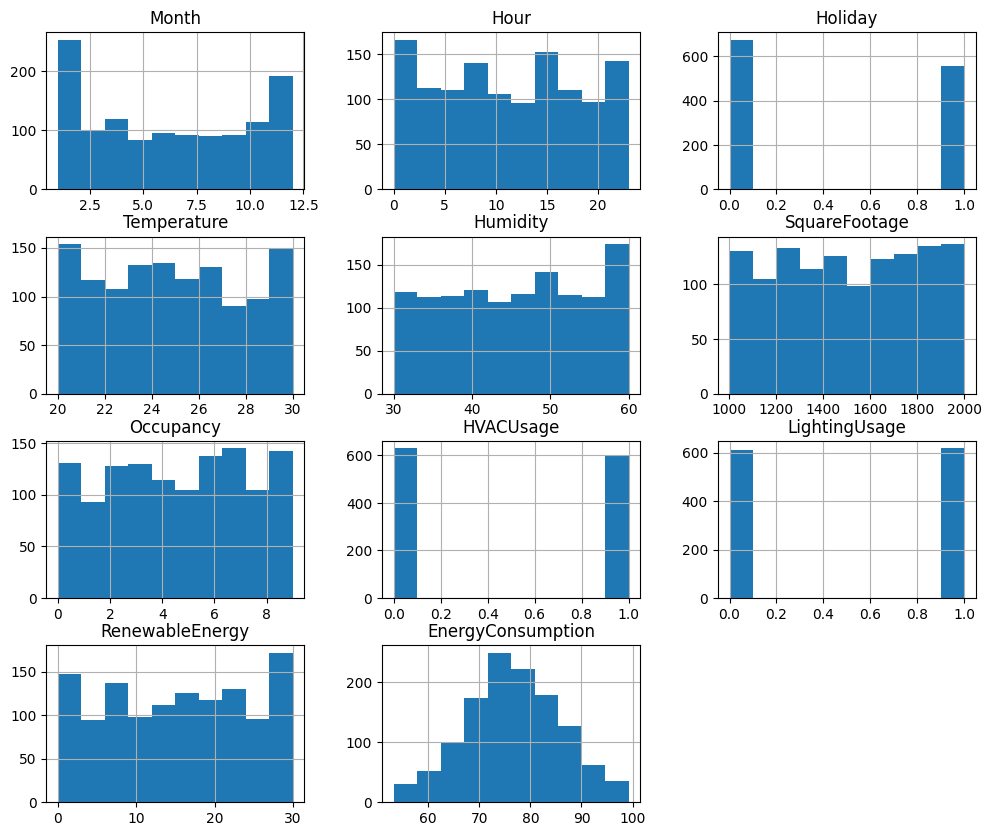

In [782]:
df.hist(figsize=(12, 10))

## Splitting the dataset into train, test and validation sets

Train, val, dan test dengan proporsi 70:10:20

In [783]:
y = df["EnergyConsumption"]
X = df.drop(columns=["EnergyConsumption"])

In [784]:
X = X.astype({col: int for col in X.columns if X[col].dtype == "bool"})

In [785]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [786]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((861, 16), (861,), (123, 16), (123,), (247, 16), (247,))

In [787]:
X_train.head()

,Month,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
2,1,19,1,20.516186,40.918500,1114.230124,8,0,1,20.489098,0,0,1,0,0,0
6,2,9,1,22.264567,40.735752,1315.024311,1,0,0,20.540906,0,0,0,0,1,0
451,11,11,0,21.150184,45.765125,1195.501453,3,0,0,5.381050,0,0,0,0,0,1
311,8,10,0,21.581821,35.376501,1049.764664,9,1,0,3.245463,0,1,0,0,0,0
1059,7,15,1,24.889613,34.873881,1999.982252,0,1,1,24.983800,0,0,0,0,0,0


In [789]:
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# **B. Comparing Sequential and Functional Keras Models for Regression (Baseline)**

## Baseline

Buatlah 2 baseline model dengan jumlah layer dan neuron yang berbeda. 1 model berupa Sequential Model dan 1 lagi berupa Functional Model. Semua hidden layer wajib menggunakan activation function bernama ReLU dan memiliki jumlah neuron minimal 2 kali lipat dari dimensi input data. Kedua model harus memiliki minimal 2 hidden layer. Lakukan training pada kedua model tersebut dengan minimal 10 epoch.

## Sequential

In [790]:
seq_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [791]:
seq_model.compile(optimizer='adam', loss='mae')

In [792]:
history_seq = seq_model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50, batch_size=32)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 76.6036 - val_loss: 74.5532
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 73.4287 - val_loss: 68.2747
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 64.8487 - val_loss: 49.3684
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.1062 - val_loss: 11.9100
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.3328 - val_loss: 10.9240
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.3400 - val_loss: 10.5692
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.4904 - val_loss: 10.4599
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.9373 - val_loss: 9.8820
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8468 - val_loss: 9.8231
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.1336 - val_loss: 9.5934
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 10.2123 - val_loss: 9.6722
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

## Functional

In [793]:
inputs = layers.Input(shape=(16,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)
functional_model = models.Model(inputs=inputs, outputs=output)

functional_model.compile(optimizer=Adam(), loss='mse')
functional_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

In [794]:
history_func = functional_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5767.9727 - val_loss: 5111.3950
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4265.4087 - val_loss: 640.8608
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 409.1876 - val_loss: 203.4068
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 216.3570 - val_loss: 163.6180
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 172.7589 - val_loss: 152.5407
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 151.0826 - val_loss: 147.2973
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 140.9002 - val_loss: 141.1991
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 139.6798 - val_loss: 135.6345
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 126.2160 - val_loss: 129.5134
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 127.0551 - val_loss: 122.7807
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 106.7833 - val_loss: 116.7304
Epoch 12/50
27/27 ━━━━━━━━

Evaluate the Sequential and Functional models before tuning

In [795]:
seq_model.evaluate(X_val, y_val, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.4252


6.503910064697266

In [796]:
functional_model.evaluate(X_val, y_val, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.9275


71.70526123046875

# **C. Refining Regression Models through Modification and Training**

Lakukan modifikasi pada kedua model anda. Anda dapat mengubah jumlah neuron dan layer ataupun activation function dari hidden layer. Anda juga dapat melakukan hyperparameter fine-tuning pada model anda. Lakukan training pada 2 modifikasi model anda.

## Sequential

Relu and Tanh

In [797]:
model_1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='tanh'),
    Dense(1)
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

history_1 = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 75.6591 - val_loss: 69.9933
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 67.4293 - val_loss: 63.2115
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.3419 - val_loss: 60.3369
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 59.8024 - val_loss: 58.0885
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 57.1247 - val_loss: 56.0008
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 55.6721 - val_loss: 53.9965
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 53.4083 - val_loss: 52.0430
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 51.5065 - val_loss: 50.1238
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 49.9112 - val_loss: 48.2294
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 47.7039 - val_loss: 46.3536
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 45.2852 - val_loss: 44.4923
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 43.

Changing optimizer and activation function - Sigmoid & SGD model config

In [798]:
model_2 = Sequential([
    Dense(64, activation='sigmoid', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
model_2.compile(optimizer='sgd', loss='mae')

history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 72.9441 - val_loss: 57.0499
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.8804 - val_loss: 7.6477
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7300 - val_loss: 7.2571
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1831 - val_loss: 7.2804
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2833 - val_loss: 7.0699
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1353 - val_loss: 6.9430
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1940 - val_loss: 7.6899
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4058 - val_loss: 6.7849
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8909 - val_loss: 6.8437
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7619 - val_loss: 6.7199
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0946 - val_loss: 6.6156
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9849 - val_loss: 6.6

Relu and dropout

In [799]:
model_3 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
])
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 76.0302 - val_loss: 73.9816
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 72.4056 - val_loss: 65.4682
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 60.6444 - val_loss: 40.6283
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 30.7414 - val_loss: 10.2118
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15.1529 - val_loss: 10.1579
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.3160 - val_loss: 10.0286
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.8133 - val_loss: 10.2467
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.3669 - val_loss: 9.7626
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.7073 - val_loss: 10.4592
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12.9559 - val_loss: 10.0443
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.6432 - val_loss: 9.4740
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.92

## Functional

In [800]:
!pip install keras-tuner --quiet

In [801]:
def build_model(hp):
    input_layer = Input(shape=(X_train.shape[1],), name='input_layer')

    x = input_layer
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'selu'])
        reg = l2(hp.Choice(f'l2_{i}', values=[0.00001, 0.0001, 0.001]))

        x = Dense(units, activation=activation, kernel_regularizer=reg)(x)

        if hp.Boolean(f'use_batchnorm_{i}'):
            x = BatchNormalization()(x)

        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)

    output_layer = Dense(1, activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = RMSprop(learning_rate=learning_rate)

    loss_fn = hp.Choice('loss', ['mse', 'mae'])

    model.compile(optimizer=opt, loss=loss_fn)

    return model

In [802]:
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='energy_model_tuning'
)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=50,
             batch_size=32,
             verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("\nBest Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

best_model.summary()

Reloading Tuner from hyperparam_tuning/energy_model_tuning/tuner0.json
Search space summary
Default search space size: 19
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu'], 'ordered': False}
l2_0 (Choice)
{'default': 1e-05, 'conditions': [], 'values': [1e-05, 0.0001, 0.001], 'ordered': True}
use_batchnorm_0 (Boolean)
{'default': False, 'conditions': []}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,121 (20.00 KB)

 Non-trainable params: 512 (2.00 KB)

# **D. Performance Evaluation of Four Models Based on a Minimum of Three Evaluation Metrics**

## Baseline

### Sequential (baseline)

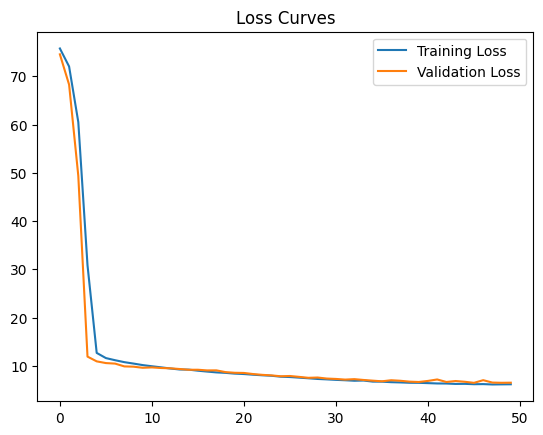

In [803]:
plt.plot(history_seq.history["loss"], label="Training Loss")
plt.plot(history_seq.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

In [804]:
y_pred_seq_b = seq_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred_seq_b))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
R2 Score: 0.2984045960435575


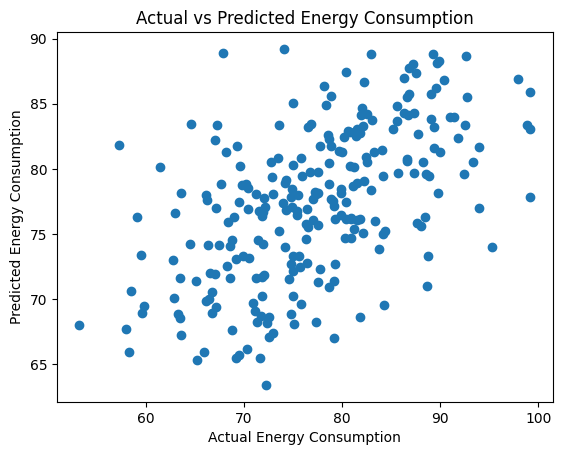

In [805]:
plt.scatter(y_test, y_pred_seq_b)
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

In [806]:
rmse_seq_b = np.sqrt(mean_squared_error(y_test, y_pred_seq_b))
print("RMSE:", rmse_seq_b)

RMSE: 7.549734591322091


### Functional (baseline)

In [807]:
y_pred_func_b = functional_model.predict(X_test)
print("R2 Score on Test Set:", r2_score(y_test, y_pred_func_b))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
R2 Score on Test Set: 0.28061509307576193


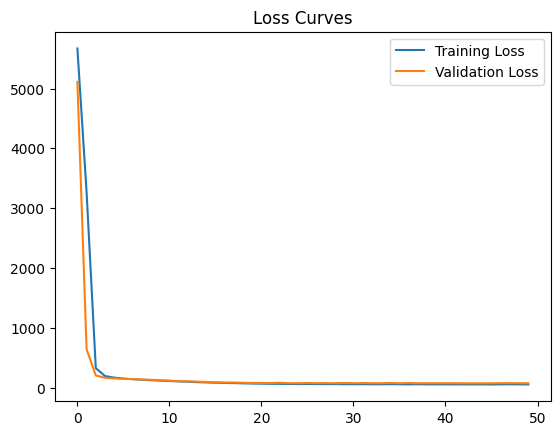

In [808]:
plt.plot(history_func.history["loss"], label="Training Loss")
plt.plot(history_func.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

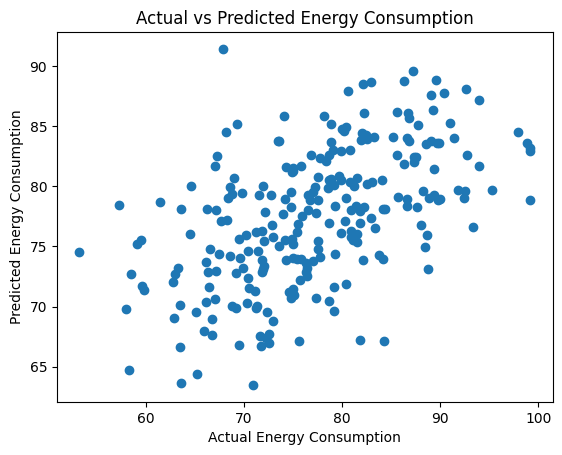

In [809]:
plt.scatter(y_test, y_pred_func_b)
plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Energy Consumption")
plt.show()

In [810]:
# rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred_func_b))
print("RMSE:", rmse)

RMSE: 7.644850160649612


## Tuned

### Sequential (tuned)

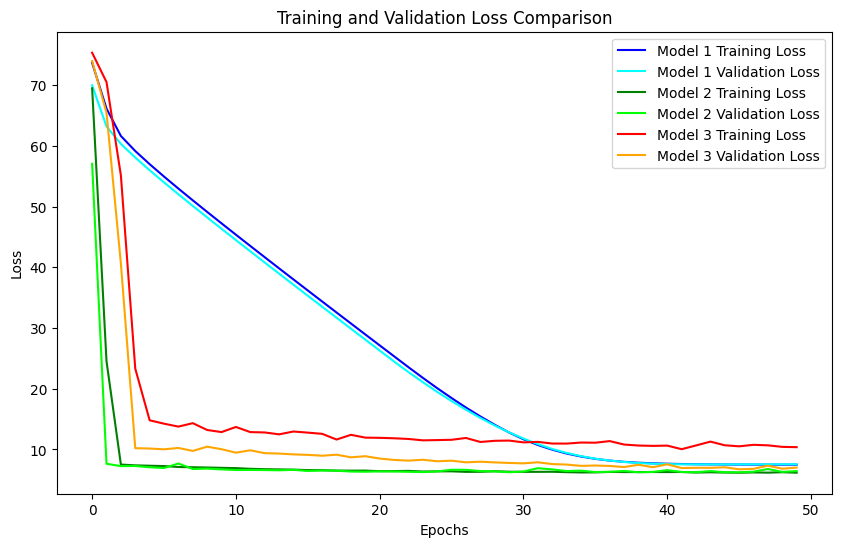

In [811]:
plt.figure(figsize=(10, 6))

plt.plot(history_1.history["loss"], label="Model 1 Training Loss", color='blue')
plt.plot(history_1.history["val_loss"], label="Model 1 Validation Loss", color='cyan')

plt.plot(history_2.history["loss"], label="Model 2 Training Loss", color='green')
plt.plot(history_2.history["val_loss"], label="Model 2 Validation Loss", color='lime')

plt.plot(history_3.history["loss"], label="Model 3 Training Loss", color='red')
plt.plot(history_3.history["val_loss"], label="Model 3 Validation Loss", color='orange')

plt.title("Training and Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [812]:
val_loss_1 = history_1.history['val_loss'][-1]
val_loss_2 = history_2.history['val_loss'][-1]
val_loss_3 = history_3.history['val_loss'][-1]

val_losses = [val_loss_1, val_loss_2, val_loss_3]

model_names = ['Model 1: Relu + Tanh', 'Model 2: Sigmoid + SGD', 'Model 3: Relu + Dropout']

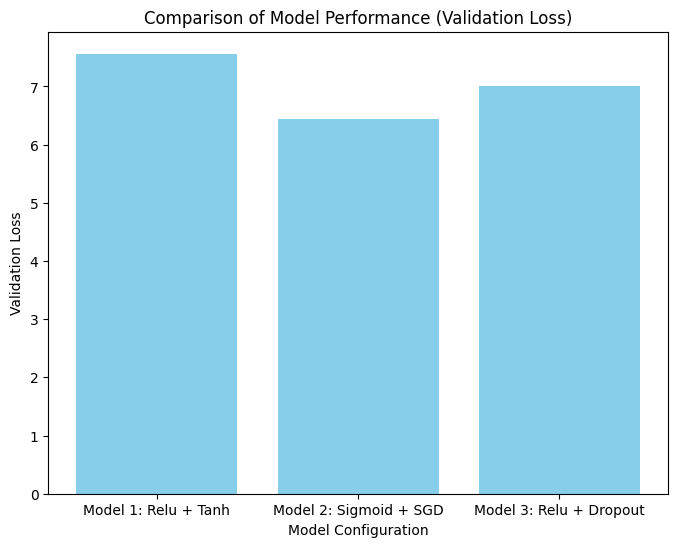

In [813]:
plt.figure(figsize=(8, 6))
plt.bar(model_names, val_losses, color='skyblue')
plt.xlabel('Model Configuration')
plt.ylabel('Validation Loss')
plt.title('Comparison of Model Performance (Validation Loss)')
plt.show()

In [814]:
y_pred_1 = model_1.predict(X_val)
y_pred_2 = model_2.predict(X_val)
y_pred_3 = model_3.predict(X_val)

r2_1 = r2_score(y_val, y_pred_1)
r2_2 = r2_score(y_val, y_pred_2)
r2_3 = r2_score(y_val, y_pred_3)

r2_scores = [r2_1, r2_2, r2_3]

model_names = ['Model 1: Relu + Tanh', 'Model 2: Sigmoid + SGD', 'Model 3: Relu + Dropout']

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


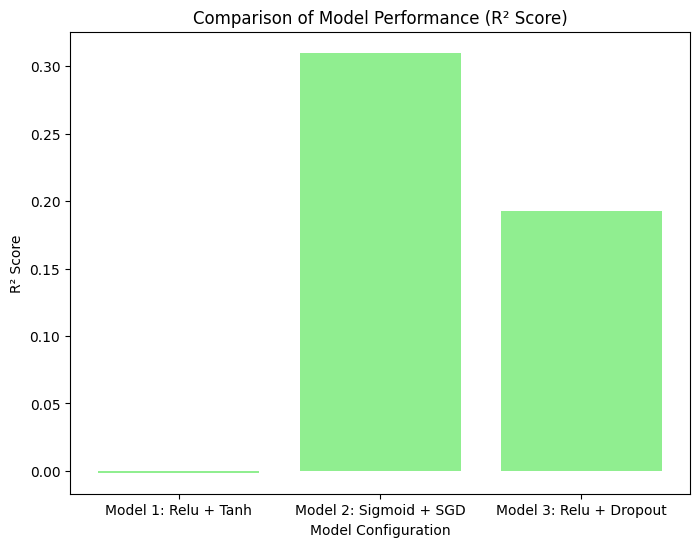

In [815]:
plt.figure(figsize=(8, 6))
plt.bar(model_names, r2_scores, color='lightgreen')
plt.xlabel('Model Configuration')
plt.ylabel('R² Score')
plt.title('Comparison of Model Performance (R² Score)')
plt.show()

In [816]:
print(f'R² for Model 1: {r2_1}')
print(f'R² for Model 2: {r2_2}')
print(f'R² for Model 3: {r2_3}')

R² for Model 1: -0.0013181945390559058
R² for Model 2: 0.3099491295166611
R² for Model 3: 0.19285389474257153


In [817]:
def print_best_rmse(history, label="Model"):
    best_train_rmse = np.min(np.sqrt(history.history["loss"]))
    best_val_rmse = np.min(np.sqrt(history.history["val_loss"]))

    print(f"{label}: Best Train RMSE = {best_train_rmse:.4f}, Best Val RMSE = {best_val_rmse:.4f}")

print_best_rmse(history_1, label="Model 1")
print_best_rmse(history_2, label="Model 2")
print_best_rmse(history_3, label="Model 3")


Model 1: Best Train RMSE = 2.7382, Best Val RMSE = 2.7469
Model 2: Best Train RMSE = 2.4840, Best Val RMSE = 2.4978
Model 3: Best Train RMSE = 3.1697, Best Val RMSE = 2.5951


**Best: Model 2**

### Functional (tuned)

In [818]:
y_pred_func = best_model.predict(X_test)
print("R2 Score on Test Set:", r2_score(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
R2 Score on Test Set: 0.28290867636061434


In [819]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_func))
print("RMSE:", rmse)

RMSE: 7.632653561513999


Best val_loss So Far: 6.282820701599121

# **E. Final Result and Link**

### Project Summary: Predicting Energy Consumption of a Solar-Powered Building

The objective of this project was to develop a machine learning model capable of predicting a building’s energy consumption. The model used input features such as time-related variables (Month, Hour, Day of Week), weather indicators (Temperature, Humidity), building characteristics (Square Footage, Occupancy), system usage (HVAC and Lighting), holiday indicators, and the amount of renewable energy generated at the time.

Two models were developed and compared:

- A baseline model using a basic Sequential & Functional neural network.
- A tuned version of the same architecture with improved hyperparameters.

### **Best Results Achieved**

| Model            | R² Score | RMSE  | Loss (MAE) |
|------------------|----------|-------|------------|
| Baseline         | 0.298    | 7.54  | 6.0642     |
| Tuned (Model 2)  | 0.319    | 2.40  | 5.9269     |


### **Interpretation**

The tuned model slightly outperformed the baseline in terms of R², increasing from 0.298 to 0.319. This means the model was able to explain approximately 32% of the variance in the energy consumption data. Although this improvement is relatively modest in terms of variance explained, the Root Mean Squared Error (RMSE) dropped substantially from 7.54 to 2.40. This indicates a significant reduction in large prediction errors.

The loss, measured as Mean Absolute Error (MAE), also improved slightly, which suggests the model became more accurate overall in its point predictions. These improvements demonstrate the value of tuning even a relatively simple neural network architecture.

### **Reflection and Suggestions for Improvement**

While the performance of the tuned model showed noticeable improvements, the relatively low R² score suggests that some important factors influencing energy consumption may not be captured in the dataset. Potentially useful additional features might include:

- Solar irradiance or sunlight hours
- Appliance-level energy usage data
- Real-time occupancy data rather than daily aggregates
- External factors such as electricity pricing or building insulation levels

Additionally, experimenting with other model types, such as gradient boosting, ensemble models, or hybrid neural architectures, may yield better performance. Feature engineering, such as adding interaction terms or temporal lags, could also further improve the model’s predictive power.

In future iterations, applying cross-validation and performing feature importance analysis would help ensure the model generalizes well and relies on the most relevant inputs.